# CFP Committee Simulator - Validation & Backtesting

This notebook validates the model against historical CFP rankings

In [4]:
# Cell 1: Historical Validation Setup
from scipy.stats import spearmanr
import pandas as pd
import warnings
import os
from dotenv import load_dotenv
warnings.filterwarnings('ignore')

# Verify API key is loaded
load_dotenv()
api_key = os.getenv('CFBD_API_KEY')
if api_key:
    api_key = api_key.strip().strip('"').strip("'")
    print(f'✅ API Key loaded (length: {len(api_key)} chars)')
    print(f'   First 10 chars: {api_key[:10]}...')
else:
    print('❌ API Key not found! Please set CFBD_API_KEY in .env file')

# Load historical CFP rankings for comparison (FBS teams only)
# These represent the final CFP rankings for each season
historical_cfp = {
    2023: ['Michigan', 'Washington', 'Texas', 'Alabama', 'Georgia', 'Florida State', 
           'Oregon', 'Ohio State', 'Missouri', 'Penn State', 'Ole Miss', 'Oklahoma'],
    2022: ['Georgia', 'Michigan', 'TCU', 'Ohio State', 'Alabama', 'Tennessee', 
           'Penn State', 'Washington', 'Clemson', 'Kansas State', 'Utah', 'USC'],
    2021: ['Alabama', 'Michigan', 'Georgia', 'Cincinnati', 'Notre Dame', 'Ohio State',
           'Baylor', 'Ole Miss', 'Oklahoma State', 'Michigan State', 'Oklahoma', 'Pittsburgh'],
    2020: ['Alabama', 'Clemson', 'Ohio State', 'Notre Dame', 'Texas A&M', 'Florida',
           'Cincinnati', 'Georgia', 'Iowa State', 'Miami', 'North Carolina', 'Indiana'],
    2019: ['LSU', 'Ohio State', 'Clemson', 'Oklahoma', 'Georgia', 'Oregon',
           'Florida', 'Alabama', 'Penn State', 'Utah', 'Wisconsin', 'Auburn'],
    2018: ['Clemson', 'Alabama', 'Notre Dame', 'Oklahoma', 'Georgia', 'Ohio State',
           'Michigan', 'UCF', 'Florida', 'LSU', 'Washington', 'Penn State'],
    2017: ['Clemson', 'Oklahoma', 'Georgia', 'Alabama', 'Ohio State', 'Wisconsin',
           'Auburn', 'USC', 'Penn State', 'Miami', 'Washington', 'UCF'],
    2016: ['Alabama', 'Clemson', 'Ohio State', 'Washington', 'Penn State', 'Michigan',
           'Oklahoma', 'Wisconsin', 'USC', 'Florida State', 'Oklahoma State', 'Colorado'],
    2015: ['Clemson', 'Alabama', 'Michigan State', 'Oklahoma', 'Iowa', 'Stanford',
           'Ohio State', 'Notre Dame', 'Florida State', 'North Carolina', 'TCU', 'Ole Miss'],
    2014: ['Alabama', 'Oregon', 'Florida State', 'Ohio State', 'Baylor', 'TCU',
           'Michigan State', 'Mississippi State', 'Georgia Tech', 'Ole Miss', 'Arizona', 'Kansas State']
}

print('\nHistorical CFP rankings loaded for validation')
print(f'Available seasons for backtesting: {list(historical_cfp.keys())}')

✅ API Key loaded (length: 64 chars)
   First 10 chars: JiPoYmTQNz...

Historical CFP rankings loaded for validation
Available seasons for backtesting: [2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014]


In [5]:
# Cell 2: Import Backtesting Module
import sys
from pathlib import Path
import importlib

# Add src to path
sys.path.insert(0, str(Path('..').resolve()))

# Force reload modules to pick up changes
if 'src.data.fetcher' in sys.modules:
    importlib.reload(sys.modules['src.data.fetcher'])
if 'src.validation.backtest' in sys.modules:
    importlib.reload(sys.modules['src.validation.backtest'])

from src.validation.backtest import (
    run_season_backtest,
    run_multiple_seasons_backtest,
    HISTORICAL_CFP_RANKINGS
)

print('✅ Backtesting module imported (reloaded to pick up changes)')
print(f'Available historical seasons: {sorted(HISTORICAL_CFP_RANKINGS.keys())}')
print('\n⚠️  If you get 401 errors, restart the kernel and run cells from the top')
print('Ready to run backtests!')

✅ Backtesting module imported (reloaded to pick up changes)
Available historical seasons: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

⚠️  If you get 401 errors, restart the kernel and run cells from the top
Ready to run backtests!


## Cell 3: Run Single Season Backtest

Run backtest for a specific historical season to see detailed metrics.


In [6]:
# Cell 3: Run Single Season Backtest
# Example: Backtest 2023 season

test_year = 2023  # Change this to test different seasons

results = run_season_backtest(
    year=test_year,
    start_week=5,  # Start from week 5 (excludes early season noise)
    max_week=None,  # Use all weeks through conference championships
    include_baselines=True  # Include baseline comparisons
)

# Display results
if 'error' not in results:
    print(f"\n{'='*80}")
    print("BACKTEST RESULTS SUMMARY")
    print(f"{'='*80}")
    print(f"Year: {results['year']}")
    print(f"Games analyzed: {results['n_games']}")
    print(f"Teams ranked: {results['n_teams']}")
    print()
    
    # Composite model results
    comp = results.get('composite', {})
    print("COMPOSITE MODEL RESULTS:")
    print("Ranking Accuracy:")
    print(f"  Spearman correlation: {comp.get('spearman_correlation', 0):.4f} (p={comp.get('spearman_p_value', 0):.4f})")
    print(f"  Target: > 0.85")
    print()
    print("Selection Accuracy:")
    print(f"  Correct selections: {comp.get('correct_selections', 0)}/{comp.get('total_selections', 12)}")
    print(f"  Accuracy: {comp.get('selection_accuracy', 0):.2%}")
    print(f"  Target: > 90%")
    print()
    print("Seeding Accuracy:")
    print(f"  Exact match: {comp.get('seeding_exact_match', 0):.2%}")
    print(f"  Within ±1: {comp.get('seeding_within_one', 0):.2%}")
    print(f"  Target: > 75%")
    print(f"  Mean Absolute Error: {comp.get('seeding_mae', 0):.2f}")
    print(f"  RMSE: {comp.get('seeding_rmse', 0):.2f}")
    print()
    print("Prediction Metrics:")
    print(f"  Prediction MAE: {comp.get('prediction_mae', 0):.2f} points")
    print(f"  Prediction RMSE: {comp.get('prediction_rmse', 0):.2f} points")
    print(f"  Brier Score: {comp.get('brier_score', 0):.4f} (lower is better)")
    print()
    print("Top 12 Comparison:")
    print(f"  Simulator: {', '.join(comp.get('top_12', []))}")
    
    # Get CFP rankings for comparison
    from src.validation.backtest import HISTORICAL_CFP_RANKINGS
    if test_year in HISTORICAL_CFP_RANKINGS:
        cfp_top12 = HISTORICAL_CFP_RANKINGS[test_year][:12]
        print(f"  CFP:       {', '.join(cfp_top12)}")
    
    # Baseline comparisons if available
    if 'elo' in results or 'srs' in results or 'home_field' in results:
        print(f"\n{'='*80}")
        print("BASELINE MODEL COMPARISONS")
        print(f"{'='*80}")
        
        baseline_models = {
            'elo': 'Simple Elo',
            'srs': 'Simple SRS',
            'home_field': 'Home Field Baseline'
        }
        
        for key, name in baseline_models.items():
            if key in results:
                baseline = results[key]
                print(f"\n{name}:")
                print(f"  Spearman correlation: {baseline.get('spearman_correlation', 0):.4f}")
                print(f"  Selection accuracy: {baseline.get('selection_accuracy', 0):.2%}")
                print(f"  Seeding accuracy (±1): {baseline.get('seeding_within_one', 0):.2%}")
                print(f"  Prediction MAE: {baseline.get('prediction_mae', 0):.2f} points")
                print(f"  Brier Score: {baseline.get('brier_score', 0):.4f}")
else:
    print(f"Error: {results['error']}")



Running backtest for 2023 season
Fetching games data (weeks 5 to 15)...
✅ Loaded 534 games
Calculating composite rankings...
✅ Calculated composite rankings for 133 teams

Calculating baseline model rankings...
  - Elo baseline...
  - SRS baseline...
  - Home field baseline...
✅ Baseline models calculated

✅ Composite Spearman correlation: 0.7762 (p=0.0030)
✅ Composite Selection accuracy: 58.33%
✅ Composite Seeding accuracy (±1): 28.57%

BACKTEST RESULTS SUMMARY
Year: 2023
Games analyzed: 534
Teams ranked: 133

COMPOSITE MODEL RESULTS:
Ranking Accuracy:
  Spearman correlation: 0.7762 (p=0.0030)
  Target: > 0.85

Selection Accuracy:
  Correct selections: 7/12
  Accuracy: 58.33%
  Target: > 90%

Seeding Accuracy:
  Exact match: 14.29%
  Within ±1: 28.57%
  Target: > 75%
  Mean Absolute Error: 2.14
  RMSE: 2.42

Prediction Metrics:
  Prediction MAE: 12.96 points
  Prediction RMSE: 17.06 points
  Brier Score: 0.1799 (lower is better)

Top 12 Comparison:
  Simulator: Alabama, LSU, Texas, M

## Cell 4: Run Multi-Season Backtest

Run backtest across multiple seasons (2014-2023) to get comprehensive validation metrics.


In [7]:
# Cell 4: Run Multi-Season Backtest with Baseline Comparisons
# This will take several minutes as it fetches data and calculates rankings for each season

# Select years to backtest (all available: 2014-2023)
years_to_test = [2023, 2022, 2021]  # Start with recent years, expand to all later

print(f"Running backtest for {len(years_to_test)} seasons with baseline comparisons...")
print("This may take several minutes...\n")

backtest_results = run_multiple_seasons_backtest(
    years=years_to_test,
    start_week=5,
    include_baselines=True  # Include baseline model comparisons
)

# Display comparison table
if not backtest_results.empty:
    print(f"\n{'='*80}")
    print("MODEL COMPARISON TABLE")
    print(f"{'='*80}")
    
    # Create comparison summary
    comparison_summary = backtest_results.groupby('model').agg({
        'spearman_correlation': 'mean',
        'selection_accuracy': 'mean',
        'seeding_within_one': 'mean',
        'prediction_mae': 'mean',
        'prediction_rmse': 'mean',
        'brier_score': 'mean'
    }).round(4)
    
    comparison_summary['selection_accuracy'] = comparison_summary['selection_accuracy'].apply(lambda x: f"{x:.2%}")
    comparison_summary['seeding_within_one'] = comparison_summary['seeding_within_one'].apply(lambda x: f"{x:.2%}")
    
    print("\nAverage Performance Across All Seasons:")
    print(comparison_summary.to_string())
    
    # Detailed results by season
    print(f"\n{'='*80}")
    print("DETAILED RESULTS BY SEASON AND MODEL")
    print(f"{'='*80}")
    display_cols = ['year', 'model', 'spearman_correlation', 'selection_accuracy', 
                    'seeding_within_one', 'prediction_mae', 'brier_score']
    print(backtest_results[display_cols].to_string(index=False))
    
    # Save results
    output_dir = Path('./data/output/validation')
    output_dir.mkdir(parents=True, exist_ok=True)
    output_path = output_dir / 'backtest_results_with_baselines.csv'
    backtest_results.to_csv(output_path, index=False)
    print(f"\n✅ Results saved to: {output_path}")
else:
    print("❌ No results generated")


Running backtest for 3 seasons with baseline comparisons...
This may take several minutes...


Running backtest for 2023 season
Fetching games data (weeks 5 to 15)...
✅ Loaded 534 games
Calculating composite rankings...
✅ Calculated composite rankings for 133 teams

Calculating baseline model rankings...
  - Elo baseline...
  - SRS baseline...
  - Home field baseline...
✅ Baseline models calculated

✅ Composite Spearman correlation: 0.7762 (p=0.0030)
✅ Composite Selection accuracy: 58.33%
✅ Composite Seeding accuracy (±1): 28.57%

Running backtest for 2022 season
Fetching games data (weeks 5 to 15)...
✅ Loaded 524 games
Calculating composite rankings...
✅ Calculated composite rankings for 131 teams

Calculating baseline model rankings...
  - Elo baseline...
  - SRS baseline...
  - Home field baseline...
✅ Baseline models calculated

✅ Composite Spearman correlation: 0.4685 (p=0.1245)
✅ Composite Selection accuracy: 66.67%
✅ Composite Seeding accuracy (±1): 37.50%

Running backtest for 

## Cell 5: Visualization of Results

Create visualizations to analyze backtest performance over time.


✅ Visualization saved to: data/output/validation/backtest_visualization_with_baselines.png


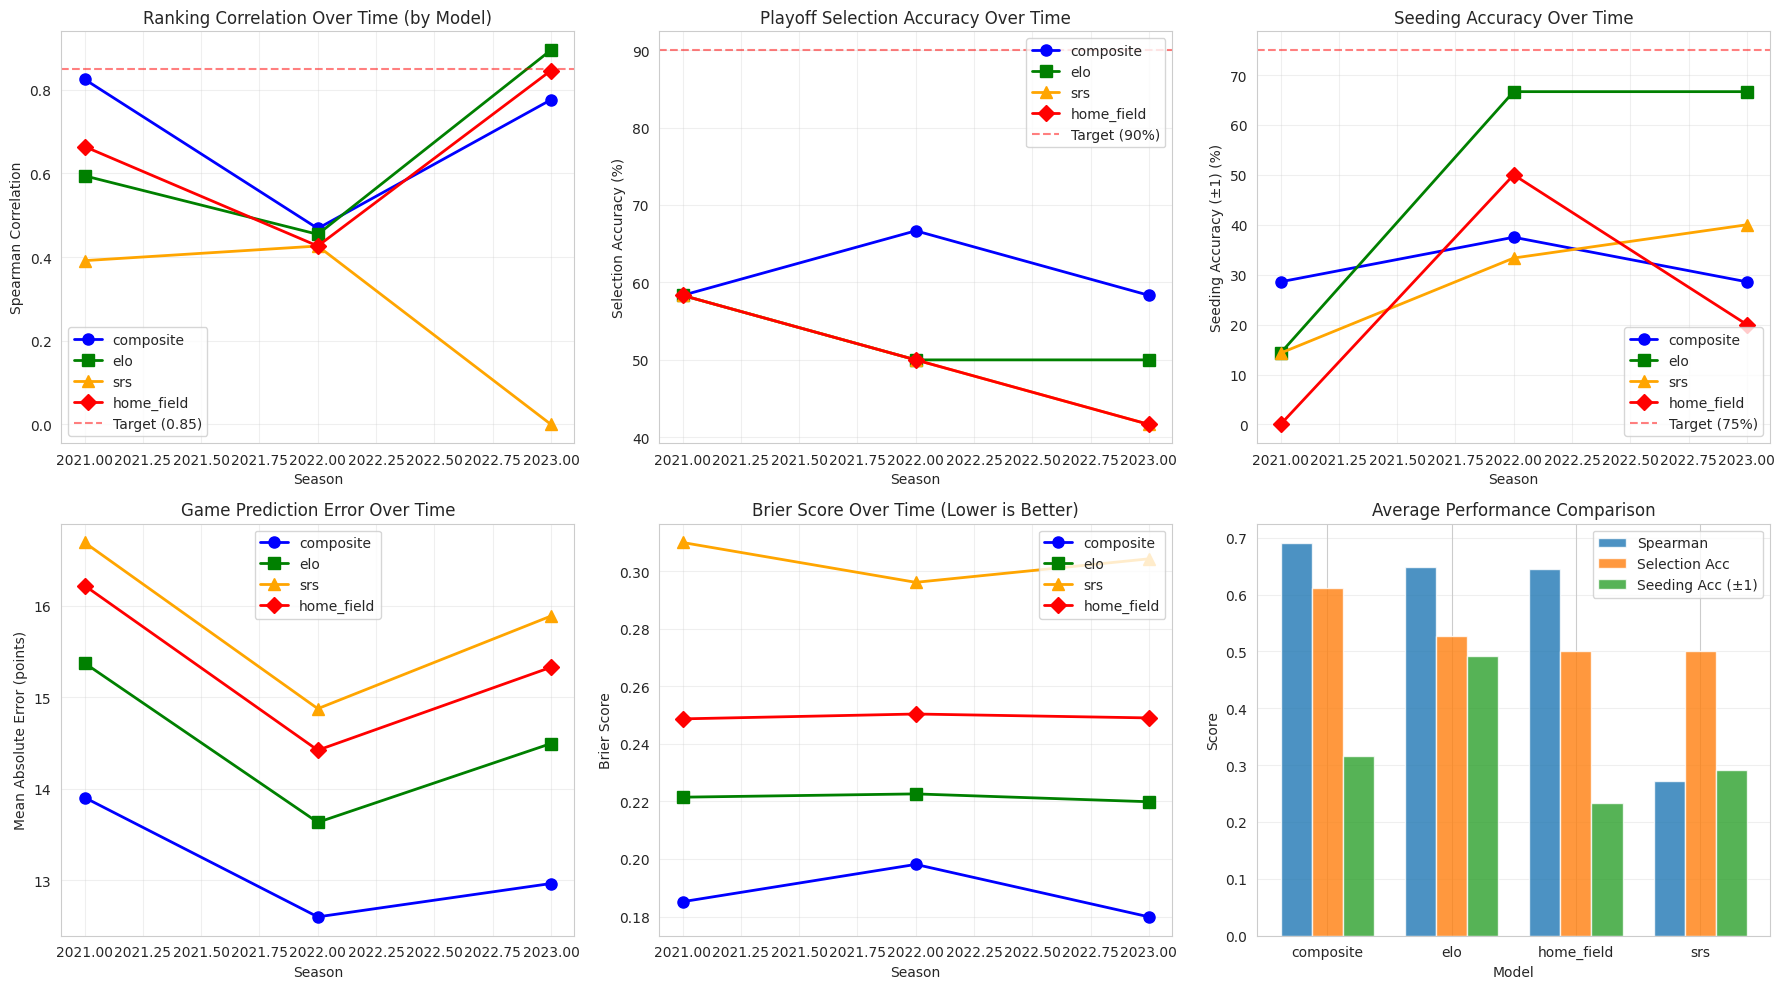

In [8]:
# Cell 5: Visualization of Results with Baseline Comparisons
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

if not backtest_results.empty and 'model' in backtest_results.columns:
    # Set style
    sns.set_style('whitegrid')
    
    # Get unique models and years
    models = backtest_results['model'].unique()
    years = sorted(backtest_results['year'].unique())
    colors = {'composite': 'blue', 'elo': 'green', 'srs': 'orange', 'home_field': 'red'}
    markers = {'composite': 'o', 'elo': 's', 'srs': '^', 'home_field': 'D'}
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Plot 1: Spearman Correlation Over Time (by model)
    for model in models:
        model_data = backtest_results[backtest_results['model'] == model].sort_values('year')
        axes[0, 0].plot(model_data['year'], model_data['spearman_correlation'], 
                      marker=markers.get(model, 'o'), linewidth=2, markersize=8,
                      label=model, color=colors.get(model, 'gray'))
    axes[0, 0].axhline(y=0.85, color='r', linestyle='--', alpha=0.5, label='Target (0.85)')
    axes[0, 0].set_xlabel('Season')
    axes[0, 0].set_ylabel('Spearman Correlation')
    axes[0, 0].set_title('Ranking Correlation Over Time (by Model)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Selection Accuracy Over Time (by model)
    for model in models:
        model_data = backtest_results[backtest_results['model'] == model].sort_values('year')
        axes[0, 1].plot(model_data['year'], model_data['selection_accuracy'] * 100,
                       marker=markers.get(model, 'o'), linewidth=2, markersize=8,
                       label=model, color=colors.get(model, 'gray'))
    axes[0, 1].axhline(y=90, color='r', linestyle='--', alpha=0.5, label='Target (90%)')
    axes[0, 1].set_xlabel('Season')
    axes[0, 1].set_ylabel('Selection Accuracy (%)')
    axes[0, 1].set_title('Playoff Selection Accuracy Over Time')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Seeding Accuracy Over Time (by model)
    for model in models:
        model_data = backtest_results[backtest_results['model'] == model].sort_values('year')
        axes[0, 2].plot(model_data['year'], model_data['seeding_within_one'] * 100,
                       marker=markers.get(model, 'o'), linewidth=2, markersize=8,
                       label=model, color=colors.get(model, 'gray'))
    axes[0, 2].axhline(y=75, color='r', linestyle='--', alpha=0.5, label='Target (75%)')
    axes[0, 2].set_xlabel('Season')
    axes[0, 2].set_ylabel('Seeding Accuracy (±1) (%)')
    axes[0, 2].set_title('Seeding Accuracy Over Time')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Plot 4: Prediction MAE Over Time (by model)
    for model in models:
        model_data = backtest_results[backtest_results['model'] == model].sort_values('year')
        axes[1, 0].plot(model_data['year'], model_data['prediction_mae'],
                       marker=markers.get(model, 'o'), linewidth=2, markersize=8,
                       label=model, color=colors.get(model, 'gray'))
    axes[1, 0].set_xlabel('Season')
    axes[1, 0].set_ylabel('Mean Absolute Error (points)')
    axes[1, 0].set_title('Game Prediction Error Over Time')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 5: Brier Score Over Time (by model)
    for model in models:
        model_data = backtest_results[backtest_results['model'] == model].sort_values('year')
        axes[1, 1].plot(model_data['year'], model_data['brier_score'],
                      marker=markers.get(model, 'o'), linewidth=2, markersize=8,
                      label=model, color=colors.get(model, 'gray'))
    axes[1, 1].set_xlabel('Season')
    axes[1, 1].set_ylabel('Brier Score')
    axes[1, 1].set_title('Brier Score Over Time (Lower is Better)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Plot 6: Average Performance Comparison (Bar Chart)
    avg_performance = backtest_results.groupby('model').agg({
        'spearman_correlation': 'mean',
        'selection_accuracy': 'mean',
        'seeding_within_one': 'mean'
    })
    
    x = np.arange(len(avg_performance.index))
    width = 0.25
    axes[1, 2].bar(x - width, avg_performance['spearman_correlation'], width, 
                   label='Spearman', alpha=0.8)
    axes[1, 2].bar(x, avg_performance['selection_accuracy'], width, 
                   label='Selection Acc', alpha=0.8)
    axes[1, 2].bar(x + width, avg_performance['seeding_within_one'], width, 
                   label='Seeding Acc (±1)', alpha=0.8)
    axes[1, 2].set_xlabel('Model')
    axes[1, 2].set_ylabel('Score')
    axes[1, 2].set_title('Average Performance Comparison')
    axes[1, 2].set_xticks(x)
    axes[1, 2].set_xticklabels(avg_performance.index)
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    # Save figure
    output_dir = Path('./data/output/validation')
    output_path = output_dir / 'backtest_visualization_with_baselines.png'
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"✅ Visualization saved to: {output_path}")
    
    plt.show()
else:
    print("⚠️  Need results with baseline comparisons. Run Cell 4 first.")
